<img src="images/header.png" alt="Header" style="width: 400px;"/>

<h1 align="center">Predictive Maintenance using NVIDIA RAPIDS and Deep Learning Models</h1>
<h4 align="center">Part 2: Training GPU LSTM models using Keras+Tensorflow for Time Series</h4>

## Overview

In the previous lab, we utilized accelerated XGBoost for classification of faulty hard drives. In this lab, we deal with data points gathered from hard drives as time series and use recurrent neural networks to predict hard disk failures. 

Companies are looking at implementing "Predictive Maintenance Procedures" to avoid downtimes by predicting the failure of a device before it happens so they can repair/replace the device, preventing costly downtimes.  

In this exercise, we will leverage the Backblaze Hard Drive SMART data to train an LSTM model that will predict potential future failures.  Unlike the previous exercise, where the XGBoost model predicted based on current data, the LSTM model will leverage time series data to look for trends prior to a failure.

One observation that comes from this exercise is that most of the work to train this model revolves around the data preparation.  We will walk through creating the "normal" and "failing" sequences that will indicate when we expect to see early warning signs of a disk failure.  Then we will use that data to train our model.

This lab covers the following topics:

* [Recurrent Networks: Long Short-Term Memory](#1)
* [Vanishing Gradient Problem and LSTMs](#2)
* [LSTM Cell Structure](#3)
* [LSTM Applications](#4)
* [Preparing the Environment](#5)
* [Load Datasets for Data Preparation](#6)
* [Preparing the Training Data](#7)
* [Creating X and y labels](#8)
    * [ Exercise 1: Create class labels](#e1)
    * [ Exercise 2: Reshaping the training data](#e2)
* [Model Design](#9)
* [Training the Model](#10)
* [Confusion Matrix](#11)
* [Optional:  CNN LSTM Architecture](#12)

Let's first discuss LSTM models.

<a name="1"></a>
## Recurrent Networks: Long Short-Term Memory

In this section, we present a brief overview of Recurrent Neural Networks (RNNs) and the Long short-term memory (LSTM) variation of RNNs, which is used in this lab to predict hard disk failures. Note that an in-depth understanding of the internal operations of LSTMs is not required to follow the application presented. However, at the end of this section, you are provided with external links for more in-depth analysis of such models and we encourage the students to read through them in order to have a better grasp of the architecture behind RNN networks.

RNNs were created to solve the memory-persistence issue found in conventional feedforward networks. Inspired by the human mind, which does not initiate the thinking process from scratch and instead uses memory-persistence based on the sequential order of events, RNNs were devised to possess such a characteristic. To accomplish this, RNNs maintain a loop that allows the information to be persistent in the network. Figure 1 depicts an RNN network where at each time step $t$, the network receives input $X_t$ and outputs a value of $y_t$. The left side of the figure shows an RNN cell with input $X$ and output $y$. There is also a loop-back of the state, which represents the memory. At a given timestep $t$, the output also depends on all previous timesteps $t-1, t-2, ..., 0$. This can also be thought of as an unrolled network with each timestep being input to a different cell and horizontal connections between cells. These connections represent the state that is passed on to the next timestep. Each timestep generates its own output that can be fed into another layer. 



<img src="img/lstm seq.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 1. The unrolled recurrent neural network</p>

While the conventional RNNs tend to look at information stored a long time ago, often we are interested in more recent data points, which in most cases suffice to predict the next state. Another well-studied issue with RNNs is the gradient vanishing-exploding problem. In a multi-layer network, gradients are calculated as a product of gradients of many activation functions. Consequently, when those gradients are close to zero, the gradient vanishes. On the other hand, when the previous gradients are bigger, it explodes. We will return to this topic later in this section.

__LSTM__ is a type of Recurrent Neural Network especially designed to prevent the neural network output for a given input from either decaying or exploding as it cycles through the feedback loops. The feedback loops are what allow recurrent networks to be better at pattern recognition than other neural networks. 
 
Length of memory of past input is critical for solving sequence learning tasks and Long short-term memory networks provide better performance compared to other RNN architectures by alleviating what is called the vanishing gradient problem.

Similar to the RNN model shown above, the LSTM Architecture consists of linear units with a self-connection that allows the flow of a value (forward pass) or gradient (backward pass) to be preserved and subsequently retrieved at the required time step. The self-recurrent unit, the memory cell, is capable of storing information which lies a dozen of time-steps in the past. This is very powerful for many tasks. For example, for text data, an LSTM unit can store information contained in the previous paragraph and apply this information to a sentence in the current paragraph.

<a name="2"></a>
## Vanishing Gradient Problem and LSTMs

A simple RNN model only has a single hidden RNN layer while a stacked RNN model (needed for advanced applications) has multiple RNN hidden layers. A common problem in deep networks is the “vanishing gradient” problem, where the gradient gets smaller and smaller with each layer until it is too small to affect the deepest layers. 

This is because small gradients or weights (values less than 1) are multiplied many times over through the multiple time steps, and the gradients shrink asymptotically to zero. This means the weights of those earlier layers won’t be changed significantly and, therefore, the network won’t learn long-term dependencies.

The gradients of neural networks are found during backpropagation.  When we multiply lots of -1 << real numbers << 1 together, we end up with a vanishing product, which leads to a very small value and hence practically no learning of the weight values – the predictive power of the neural network then plateaus.

With the memory cell in LSTMs, we have continuous gradient flow (errors maintain their value) which thus eliminates the vanishing gradient problem and enables learning from sequences which are hundreds of time steps long.

LSTM models are powerful enough to learn the most important past behaviours and understand whether or not those past behaviours are important features in making future predictions.

<a name="3"></a>
## LSTM Cell Structure

An LSTM cell block is made of various components called the cell state, the input gate, the forget gate, and the output gate.  The cell state runs along the entire length of the cell and interacts with each of the gates.  The gates are a way to control the information that gets through to the cell state.

Here is a graphical representation of the LSTM cell:


<img src="img/LSTM cell.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 2. LSTM Cell</p> <p style="text-align: center;color:gray;font-size:12px;"> Image from book: <i>Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems</i>
 by Aurélien Géron </p>

Notice first, on the bottom, we have our new sequence value $x_t$ being concatenated to the previous output from the cell $h_{t-1}$. The first step for this combined input is for it to be squashed via a $tanh$ layer. Next, the output of the $tanh$ operation is passed through an input gate. An input gate is a layer of sigmoid activated nodes whose output is multiplied by the squashed input. These gate sigmoids can act to “kill off” any elements of the input vector that aren’t required and need to be forgotten. A sigmoid function outputs values between 0 and 1, so the weights connecting the input to these nodes can be trained to output values close to zero to “switch off” certain input values (or, conversely, outputs close to 1 to “pass through” other values).

The next step in the flow of data through this cell is the internal state / forget gate loop. LSTM cells have an internal state variable $c_t$. This variable lagged one time step, i.e. $c_{t-1}$, is added to the input data to create an effective layer of recurrence. This addition operation, instead of a multiplication operation, helps to reduce the risk of vanishing gradients. However, this recurrence loop is controlled by a forget gate. This works the same as the input gate but instead helps the network learn which state variables should be “remembered” or “forgotten”.

As the final gate, we have an output layer $tanh$ squashing function (re-scale the numbers between -1 and 1), the output of which is controlled by an output gate. This gate determines which values are actually allowed as an output from the cell $h_t$.

Last, running along the top of the cell is the cell state, that leverage pointwise multiplication operations to interact with each of the gates.  


To have a more in-depth understanding of LSTM networks and relative analysis, we recommend the curious audience to read the following articles:

 - [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
 
 - [Tutorial for Implementing Long Short-Term Memory](https://heartbeat.fritz.ai/a-beginners-guide-to-implementing-long-short-term-memory-networks-lstm-eb7a2ff09a27)
 
 - [LSTM: A Search Space Odyssey](https://arxiv.org/pdf/1503.04069.pdf)



<a name="4"></a>
## LSTM Applications

LSTMs, due to their ability to learn long term dependencies, are applicable to a number of sequence learning problems including language modelling and translation, acoustic modelling of speech, speech synthesis, speech recognition, audio and video data analysis, handwriting recognition and generation, sequence prediction, and protein secondary structure prediction.

In this lab, we apply the LSTM model to the Backblaze data we introduced in the previous lab to create a model that predicts the hard disk failure based on the recorded data-points at least a few days before the actual failure. 

<a name="5"></a>
## Preparing the Environment

Below we are importing the required libraries and tools we use throughout this notebook:


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import tensorflow as tf

print(tf.__version__)

# Suppress TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# prevent keras/tf from allocating all gpu memory
gpu=2 # set to number of GPU we want to leverage for training
tf.config.set_soft_device_placement(True) # set soft device placement to enabled
tf.debugging.set_log_device_placement(True) # turns logging for device placement decisions on
for each_device in tf.config.experimental.list_physical_devices('GPU'): 
    tf.config.experimental.set_memory_growth(each_device, True)

2.0.0


<a name="6"></a>
## Load Datasets for Data Preparation

For your convenience, we have filtered and stored the `ST4000DM000` model data points in a pickle file. In the following cell, we are reloading the pickle file into the memory.

In [2]:
import pandas as pd

data_dir = './data/'

# Files from Lab 1
train_pkl_file = 'Lab1-2017-Full-ST4000DM000.pkl'
test_pkl_file = 'Lab1-2016-Q4-ST4000DM000.pkl'

# Load our training and test set from previous step
print("Reading in training and test SMART data stored in previous exercise...")
df_train = pd.read_pickle(data_dir+train_pkl_file)
df_test = pd.read_pickle(data_dir+test_pkl_file)

print(df_train.shape)
print(df_test.shape)

Reading in training and test SMART data stored in previous exercise...
(12237899, 53)
(3196552, 53)


Let's take another look at the data samples:

In [3]:
df_train.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
4,2017-02-01,Z305B2QN,ST4000DM000,4000787030016,0,117.0,124084032.0,91.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,9690.0,100.0,3.179327e+10,100.0,8.596073e+09
7,2017-02-01,Z302A0YH,ST4000DM000,4000787030016,0,109.0,22057080.0,92.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,17310.0,100.0,2.169678e+10,100.0,1.860347e+11
8,2017-02-01,Z305BT0W,ST4000DM000,4000787030016,0,117.0,119535272.0,93.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,8514.0,100.0,2.755353e+10,100.0,1.631456e+10
12,2017-02-01,Z302A0YE,ST4000DM000,4000787030016,0,115.0,90592144.0,92.0,0.0,100.0,...,100.0,0.0,200.0,564.0,100.0,18051.0,100.0,2.150714e+10,100.0,2.376942e+11
13,2017-02-01,Z302PGH8,ST4000DM000,4000787030016,0,120.0,240109536.0,92.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,14303.0,100.0,1.645696e+10,100.0,7.311286e+10


We need to further process the data before the training phase. Each "raw" data column has a duplicated "normalized" version (example. smart_1_raw and smart_2_normalized) and while values of the pairs are different because of normalization, they do not possess extra information. Similar to the previous lab, we choose to eliminate the "normalized" columns.

We also need to sort the columns based on the `serial_number` and `date` columns. Since we are dealing with time series data, the only meaningful way to process is to have them sorted, first by the related serial_number and second by the date recorded. The `prepare_dataframe` function is intended to accomplish these steps.

In [4]:
def prepare_dataframe(df):
    print("Removing unnecessary columns")
    
    # find and drop all normalized columns
    cols = [c for c in df.columns if (c.lower().find("normalized")!=-1)]
    df=df.drop(columns=cols)

    # also drop the model and capacity columns as we don't need them
    df = df.drop(columns=['model','capacity_bytes'])

    # convert string dates to datetime format
    df['date'] = pd.to_datetime(df['date'])

    # sort data by serial number and dates so ready for sequence creation
    print("Sorting the data frame based on serial number and date")
    df = df.sort_values(by=['serial_number', 'date'], axis=0, ascending=True)
    df = df.reset_index(drop=True)
    
    # ensure no NaN's in data
    df = df.fillna(0)
    
    return df

We run the preparation step over both train and test datasets.

In [5]:
print("Processing train set...")
df_train = prepare_dataframe(df_train)

print("")
print("Processing test set...")
df_test = prepare_dataframe(df_test)

Processing train set...
Removing unnecessary columns
Sorting the data frame based on serial number and date

Processing test set...
Removing unnecessary columns
Sorting the data frame based on serial number and date


### Create sequences from data sets

In this section, we create sequences of data based on the serial numbers. To have a better understanding of this process, we need to elaborate on the architecture of the deep learning model that consumes the data. We start with a high-level architecture at this section, and later we will elaborate the model in more details.


<img src="img/lstm_simple.png" style="margin-top:10px;width:600px;"/>
<p style="text-align: center;color:gray"> Figure 3. Basic RNN model. </p>

In figure 3, a simplified version of the RNN architecture is shown. Here we have `n` time steps representing each data point in the DataFrame. Also, only the last RNN (LSTM) cell is outputting the value $y$, which in our model indicates whether the data sequence ends up in a failure state or not.
Note that the input values $x_1, x_2, …, x_n$ are multi-dimensional values and not single scalars.

One important question is how to choose the value $n$. Our dataset contains lengthy time series sequences for each hard drive. Below, we choose a sequence length of _5_ and later ask the students to experiment with other values and justify their value of choice.

### Preparing Training Data

Normally, we'd create sequences from all of the data that we have.  Even with the small data sets that we have, that can take more than 4 hours.  For this lab, we will simplify the process to make the time reasonable.

To create 'sequences' for training our Time Series models, we will first sort the data by serial number and date (which we did above).  This will allow us to grab groups of sequential records to create each sequence. 

Next, we reviewed all the records to ensure that we had data reported for every day so we could create consistent sequences.  In the case of this data set, for 2017, there were 2 holes where data wasn't reported, and we used a fill-forward technique to recreate this data.

To create models to predict into the future, we will use a "lookahead_days" parameter to see how far in the future we want the model to be trained to identify failures.  Determining how many days to lookahead is very dependent on your environment and the nature of the failures.  For the hard drives, during the creation of the lab, we tried 14 days, but we the models we created, with the minimal amount of data we use for this lab, were not very accurate.  In looking at the visualizations from Lab 1, some of the anomalous sensor values seemed to only occur 1-2 days prior to the failure, and we have selected 2 days.  In practice, this is another parameter that can be tuned.

With the data all prepared, we can create sequences.

Failed Records:

Next, we create failed record sequences.  To do this, we will find all of the failed disk records.  Then, we will move back "lookahead_days" as this will be the last record in the sequence we are creating.  Then, we will take the previous $sequence length-1$ records and combine it with this last sequence record to create a sequence of records that ends up with a failure "lookahead_days" later.  In the case of our data set, there are so few failed disks (~1600) that we will use all of them to train our model.

Normal Records:

For normal records, we will first identify all disks (by serial_number) that did not have a failure.  Then, we will select a subset of the disks (to shorten the time) to create sequences for.  To create the sequence, we will walk sequentially through the records for a given disk and create sequences from that record and the next $sequence length-1$ records.  So, our first sequence (for length 5) would be Day 1-Day 5.  Then, we will go to the next day and create a sequence of Day 2-Day6.

In [6]:
# Routine to return serial numbers of good and bad disks

def get_disk_serials(df, num_disks):
    # Get failed serial numbers
    failed_serials = df[df['failure'] == 1]['serial_number'].unique().tolist()

    # Get serial numbers for disks that didn't fail - first remove failed disks
    df_tmp = df[~df.serial_number.isin(failed_serials)]
    normal_serials = df_tmp.serial_number.value_counts()[:num_disks].index.tolist()

    print('Normal Disk Serials:',len(normal_serials))
    print('Failed Disk Serials:',len(failed_serials))

    return normal_serials, failed_serials

This routine checks all the records for a given serial number to ensure we are not skipping any days.  For consistency in training our model, we need to ensure that there is a data record for each date.

In [7]:
import numpy as np

def adjust_dates(df_loc): 
    df_mod = pd.DataFrame()
    cur_serial = df_loc['serial_number'].unique().tolist()[0]
    col_list = df_loc.columns.tolist()
    cur_dates = df_loc['date'].values
    
    # determine number of days between last record and first record
    num_date_range = int((cur_dates[-1] - cur_dates[0]).astype('timedelta64[D]')/ np.timedelta64(1, 'D'))+1
    
    # do we have records for each day or are there holes ?  If so, fill them.
    if num_date_range > cur_dates.shape[0]:
        i_low = 0
        
        # step through all days to ensure next date correct
        for i in range(cur_dates.shape[0]-1): 
            
            # calculate number of days between current data and next data - should be 1 day
            diff_days = int((cur_dates[i+1] - cur_dates[i]).astype('timedelta64[D]')/ np.timedelta64(1, 'D'))
            
            # if not 1 day, fill in missing days with forward fill
            if diff_days > 1:
                df_mod = df_mod.append(df_loc.iloc[i_low:i+1])
                tmp_array = np.empty((diff_days-1,len(col_list),))
                tmp_array[:] = np.nan
                df_add = pd.DataFrame(tmp_array,columns=col_list)
                df_add['date'] = [ cur_dates[i] + np.timedelta64(1, 'D')*j for j in range(1,diff_days)]
                df_mod = df_mod.append(df_add)
                i_low = i+1

        # add missing records and use forward fill to update missing sensor data
        df_mod = df_mod.append(df_loc.iloc[i_low:])
        df_mod = df_mod.fillna(method="ffill")
    else:
        df_mod = df_loc 
    
    return df_mod 

This routine fills in missing data to ensure we have consistent sequences.

In [8]:
def fix_date_gaps(df, normal_serials=None, failed_serials=None):
    df_fixed = pd.DataFrame()

    serials_list = normal_serials + failed_serials 
    for i, cur_serial in enumerate(serials_list): 
        df_fixed = df_fixed.append(adjust_dates(df[df['serial_number'] == cur_serial]))
        
    return df_fixed.reset_index(drop=True)

This routine builds failed sequences by finding the failure and then going back "lookahead" days and building a sequence based on the previous "sequence_length" days.

In [9]:
# Routine to return failed sequences 
def create_failed_sequences(df, sequence_length, lookahead):

    failed_serials = df.serial_number.unique().tolist()
    print("Number of failed serials : ", len(failed_serials)) 

    failed_seq_list = []
    for serial in failed_serials:
        df_tmp = df[df['serial_number'] == serial]
        df_tmp = df_tmp.reset_index(drop=True)
        num_recs = df_tmp.index.size
        
        # if enough records, add failed sequence
        if num_recs > (sequence_length+lookahead): 
            # find first failure
            df_failed = df_tmp[df_tmp['failure'] == 1]
            
            # find end of sequence - going back "lookahead" days from failure
            idx2 = df_failed.index[0] - lookahead + 1
            
            # find beginning of sequence
            idx1 = idx2 - sequence_length
            
            if idx1 > 0: 
                failed_seq_list.append(df_tmp.iloc[idx1:idx2,:])
    
    print("Number of failed sequences :", len(failed_seq_list)) 
    
    return pd.concat(failed_seq_list)

In [10]:
# Routine to pick some serial_numbers and create all sequences from those disks up to num_normal sequences
def create_normal_sequences(df, sequence_length, num_normal, lookahead, day_step=1):
    normal_seq_list = []
    num_seq = 0
    
    # ensure no failed sequences
    if df[df['failure'] == 1].index.size > 0: return None 
    
    # get list of normal serial numbers
    normal_serials = df.serial_number.unique().tolist()
    
    print("Number of normal serials : ", len(normal_serials)) 
    
    for serial in normal_serials:
        df_tmp = df[df['serial_number'] == serial]
        num_recs = df_tmp.shape[0]
        
        # 
        for i in range(0, num_recs-(sequence_length+lookahead)+1, day_step):
            if (num_seq < num_normal):
                normal_seq_list.append(df_tmp.iloc[i:i+sequence_length])
                num_seq += 1
    
    print("Number of normal sequences :", len(normal_seq_list))
    
    return pd.concat(normal_seq_list)


In [11]:
# Routine to add column "sequence_label" indicating whether this was a normal or failed sequence.
# We will use this later for as label for training.
def label_sequence(df, label):
    df.insert(2, 'sequence_label', np.full(df.shape[0], label), True)
    return

In [12]:
# Specify key parameters - you can change and re-run to test different configurations
sequence_length = 5          # Number of days in sequence to train to detect and predict failure
lookahead_days = 1           # Number of days in future to predict failure
num_normal_disks = 20        # Maximum number of normal disks to look at
max_normal_sequences = 4000  # Maximum number of normal sequences to create

In [13]:
# get pools of serial numbers for good and bad disks
print("Determining good and bad disk serial numbers")
normal_serials, bad_serials = get_disk_serials(df_train, num_normal_disks)

df_selected = df_train[df_train.serial_number.isin(normal_serials + bad_serials)]
print('Total Records before fixing date gaps :', df_selected.shape)

df_selected = fix_date_gaps(df_selected, normal_serials, bad_serials)
print('Total Records after fixing date gaps  :', df_selected.shape)
    
# get sequences
print("Creating sequences for normal disks")
normal_sequences = create_normal_sequences(df_selected[df_selected.serial_number.isin(normal_serials)], 
                                           sequence_length, max_normal_sequences, lookahead_days)

# add field to indicate normal sequence
label_sequence(normal_sequences, 0)

print("Creating sequences for failed disks")
failure_sequences = create_failed_sequences(df_selected[df_selected.serial_number.isin(bad_serials)],
                                            sequence_length, lookahead_days)

# add field to indicate failing sequence
label_sequence(failure_sequences, 1)

# combine to creating training set
train_samples = pd.concat([normal_sequences, failure_sequences]).reset_index(drop=True)

Determining good and bad disk serial numbers
Normal Disk Serials: 20
Failed Disk Serials: 1061
Total Records before fixing date gaps : (189830, 27)
Total Records after fixing date gaps  : (194895, 27)
Creating sequences for normal disks
Number of normal serials :  20
Number of normal sequences : 4000
Creating sequences for failed disks
Number of failed serials :  1061
Number of failed sequences : 1041


Let's look at a few normal disk sequences.  You should see 'sequence_length' records in a row that are sequential days for the same disk.  You'll see the first sequence contains day 1-day 5 (for sequence_length 5) and the second sequence contains day 2-day 6.

In [14]:
normal_sequences.head(2*sequence_length)

,date,serial_number,sequence_label,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2017-01-01,Z304KDD8,0,0.0,220047008.0,0.0,4.0,0.0,470356640.0,10861.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10782.0,3.616701e+10,1.408089e+10
1,2017-01-02,Z304KDD8,0,0.0,153186864.0,0.0,4.0,0.0,470798034.0,10885.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10807.0,3.619833e+10,1.409885e+10
2,2017-01-03,Z304KDD8,0,0.0,64296624.0,0.0,4.0,0.0,471303635.0,10909.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10830.0,3.624176e+10,1.411733e+10
3,2017-01-04,Z304KDD8,0,0.0,167224520.0,0.0,4.0,0.0,472492676.0,10933.0,...,0.0,0.0,5384.0,24.0,0.0,0.0,0.0,10854.0,3.629774e+10,1.415116e+10
4,2017-01-05,Z304KDD8,0,0.0,153569464.0,0.0,4.0,0.0,473159118.0,10957.0,...,0.0,0.0,5385.0,26.0,0.0,0.0,0.0,10878.0,3.636528e+10,1.415976e+10
1,2017-01-02,Z304KDD8,0,0.0,153186864.0,0.0,4.0,0.0,470798034.0,10885.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10807.0,3.619833e+10,1.409885e+10
2,2017-01-03,Z304KDD8,0,0.0,64296624.0,0.0,4.0,0.0,471303635.0,10909.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10830.0,3.624176e+10,1.411733e+10
3,2017-01-04,Z304KDD8,0,0.0,167224520.0,0.0,4.0,0.0,472492676.0,10933.0,...,0.0,0.0,5384.0,24.0,0.0,0.0,0.0,10854.0,3.629774e+10,1.415116e+10
4,2017-01-05,Z304KDD8,0,0.0,153569464.0,0.0,4.0,0.0,473159118.0,10957.0,...,0.0,0.0,5385.0,26.0,0.0,0.0,0.0,10878.0,3.636528e+10,1.415976e+10
5,2017-01-06,Z304KDD8,0,0.0,108197000.0,0.0,4.0,0.0,473535289.0,10981.0,...,0.0,0.0,5385.0,26.0,0.0,0.0,0.0,10903.0,3.639622e+10,1.416600e+10


Now, let's look "lookahead" days past the first failed sequence to see the actual failure in the future.

In [15]:
print('First Failure Sequence')
failure_sequences.head(sequence_length)

First Failure Sequence


,date,serial_number,sequence_label,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
49,2017-02-19,S30070F5,1,0.0,83295096.0,0.0,8.0,0.0,531725607.0,25281.0,...,0.0,2.0,8249.0,30.0,0.0,0.0,0.0,25210.0,2.316110e+10,8.881304e+10
50,2017-02-20,S30070F5,1,0.0,73725216.0,0.0,8.0,0.0,532565600.0,25305.0,...,0.0,2.0,8249.0,29.0,0.0,0.0,0.0,25234.0,2.316667e+10,8.884915e+10
51,2017-02-21,S30070F5,1,0.0,41438696.0,0.0,8.0,0.0,533423914.0,25329.0,...,0.0,2.0,8249.0,29.0,0.0,0.0,0.0,25258.0,2.317391e+10,8.888442e+10
52,2017-02-22,S30070F5,1,0.0,25482720.0,0.0,8.0,0.0,534282220.0,25353.0,...,0.0,2.0,8249.0,30.0,0.0,0.0,0.0,25282.0,2.318148e+10,8.892227e+10
53,2017-02-23,S30070F5,1,0.0,233703728.0,0.0,8.0,0.0,535136227.0,25377.0,...,0.0,2.0,8249.0,29.0,0.0,0.0,0.0,25306.0,2.318899e+10,8.895852e+10


Now, let's check the record "lookahead" days in the future to see that we did encounter a failure on that date.

In [16]:
first_fail_serial = failure_sequences['serial_number'].iloc[0]
df_tmp = df_train[df_train['serial_number'] == first_fail_serial]
first_fail_index = df_tmp[df_tmp['failure'] == 1].iloc[0]

print("We should see a failure below",lookahead_days, "days after the sequence above.")
df_tmp[df_tmp['failure'] == 1].head(1)

We should see a failure below 1 days after the sequence above.


,date,serial_number,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
16559,2017-02-24,S30070F5,1,184511376.0,0.0,8.0,0.0,535953309.0,25401.0,0.0,...,0.0,2.0,8249.0,29.0,0.0,0.0,0.0,25330.0,2.319425e+10,8.899058e+10


Let's output how many training records we have.  It's not a lot of data, but the process we go through is that same whether it's 1000's or 1M's of records.

In [17]:
# check samples
num_seq = int(train_samples.shape[0] / sequence_length)
print('Training Sequences:', num_seq)

Training Sequences: 5041


Since our objects are huge and in order to prevent memory leaks, we are going to store the data, clear the objects, and retrieve them later.

In [18]:
import gc

# Store filesnames for later use
lab2_train_file = data_dir + 'Lab2-LSTM_train_data_' + str(sequence_length) + '.pkl'
lab2_test_file =  data_dir + 'Lab2-LSTM_test_data_' + str(sequence_length) + '.pkl'

# Save away training data
train_samples.to_pickle(lab2_train_file)
del (train_samples)
gc.collect()

0

Next, we repeat the same process for the test set.

In [19]:
# get pools of serial numbers for good and bad disks
print("Determining good and bad disk serial numbers")
normal_serials, bad_serials = get_disk_serials(df_test, num_normal_disks)

df_selected = df_test[df_test.serial_number.isin(normal_serials + bad_serials)]
print('Total Records before fixing date gaps :', df_selected.shape)

df_selected = fix_date_gaps(df_selected, normal_serials, bad_serials)
print('Total Records after fixing date gaps  :', df_selected.shape)
    
# get sequences
print("Creating sequences for normal disks")
normal_sequences = create_normal_sequences(df_selected[df_selected.serial_number.isin(normal_serials)], 
                                           sequence_length, max_normal_sequences, lookahead_days)

# add field to indicate normal sequence
label_sequence(normal_sequences, 0)

print("Creating sequences for failed disks")
failure_sequences = create_failed_sequences(df_selected[df_selected.serial_number.isin(bad_serials)],
                                            sequence_length, lookahead_days)

# add field to indicate failure sequence
label_sequence(failure_sequences, 1)

# combine to creating training set
test_samples = pd.concat([normal_sequences, failure_sequences]).reset_index(drop=True)

Determining good and bad disk serial numbers
Normal Disk Serials: 20
Failed Disk Serials: 234
Total Records before fixing date gaps : (12605, 27)
Total Records after fixing date gaps  : (12605, 27)
Creating sequences for normal disks
Number of normal serials :  20
Number of normal sequences : 1740
Creating sequences for failed disks
Number of failed serials :  234
Number of failed sequences : 216


Now that we've created samples for testing let's store them away.

In [20]:
# store away training and test samples
test_samples.to_pickle(lab2_test_file)
del (test_samples)
gc.collect()

0

<a name="8"></a>
## Creating X and y labels

We are going to cleanly read the LSTM training and test data sets in.

In [21]:
# Read datasets back in cleanly
df_train = pd.read_pickle(lab2_train_file)
df_test = pd.read_pickle(lab2_test_file)

df_train.head(sequence_length)

,date,serial_number,sequence_label,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2017-01-01,Z304KDD8,0,0.0,220047008.0,0.0,4.0,0.0,470356640.0,10861.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10782.0,3.616701e+10,1.408089e+10
1,2017-01-02,Z304KDD8,0,0.0,153186864.0,0.0,4.0,0.0,470798034.0,10885.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10807.0,3.619833e+10,1.409885e+10
2,2017-01-03,Z304KDD8,0,0.0,64296624.0,0.0,4.0,0.0,471303635.0,10909.0,...,0.0,0.0,5384.0,26.0,0.0,0.0,0.0,10830.0,3.624176e+10,1.411733e+10
3,2017-01-04,Z304KDD8,0,0.0,167224520.0,0.0,4.0,0.0,472492676.0,10933.0,...,0.0,0.0,5384.0,24.0,0.0,0.0,0.0,10854.0,3.629774e+10,1.415116e+10
4,2017-01-05,Z304KDD8,0,0.0,153569464.0,0.0,4.0,0.0,473159118.0,10957.0,...,0.0,0.0,5385.0,26.0,0.0,0.0,0.0,10878.0,3.636528e+10,1.415976e+10


Before creating X and y labels, there are certain columns that we need to get rid of. As an example, we can safely remove the `date` column. While the date column values helped us creating the sequences, they cannot be used for training/inference purposes (why?).

Also, the `serial_number` and `failure` columns will not be used. Discuss why these two columns are not required.

<a name="e1"></a>
### Exercise 1: Create class labels

To train the model, we need to have the class labels for each sample. Complete the "TODO" sections below to store the class labels for `df_train` and `df_test` DataFrames.

In [23]:
# index data will hold disk serial numbers for relevant samples. We do not need serial numbers as training or testing features
drop_columns_list = ['date','serial_number', 'failure', 'sequence_label']

x_train = df_train.drop(columns=drop_columns_list)
x_test = df_test.drop(columns=drop_columns_list)

y_train = df_train['sequence_label']
y_test = df_test['sequence_label']

If you get stuck, click [here](#a1) for an answer.

Previously, we removed the normalized columns and kept the raw ones. The reason behind this was that the normalized columns are generated based on much more samples from the original set and hence, do not represent the distribution accurately. In this section, we are going to normalize values in both test and train sets. We will utilize [preprocessing.StandardScaler().fit()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method for this purpose, but first we need to convert the Pandas DataFrame to NumPy arrays:

In [24]:
from sklearn import preprocessing

# X train data
x_train = x_train.values.astype(np.float64)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# X test data
x_test = x_test.values.astype(np.float64)
x_test = scaler.transform(x_test)

<a name="e2"></a>
### Exercise 2: Reshaping the training data

Next, we need to reshape the array to get 3D data (num_samples, timesteps, num_features) needed to feed LSTM. Fix to TODO sections below to reshape the data accordingly.

In [25]:
print("Reshaping training and test data for LSTM")
print("- Original Train Shape:", x_train.shape)

x_train = x_train.reshape(int(x_train.shape[0]/sequence_length), sequence_length, x_train.shape[1])
x_test = x_test.reshape(int(x_test.shape[0]/sequence_length), sequence_length, x_test.shape[1])

print("- Final Train Shape:   ", x_train.shape)
data_shape = x_train.shape[1:]

Reshaping training and test data for LSTM
- Original Train Shape: (25205, 24)
- Final Train Shape:    (5041, 5, 24)


If you get stuck, click [here](#a2) for an answer.

Finally we create the y labels (failed or not) for both test and train sets (last column of `y_train` and `y_test`):

In [26]:
# Y train data
y_train = y_train.values[0::sequence_length]

# Y test data
y_test = y_test.values[0::sequence_length]

gc.collect()

0

<a name="9"></a>
## Model Design
We've finally arrived at the neural network design! Previously, we provided a simplistic overview of the network. In this section, we are going to discuss the full network design first and then build the model using tf.keras.

In figure 3, we showed how we utilize the output of the last LSTM node in the sequence to create the relevant output. In reality, one-layer LSTM nodes are barely enough to capture the information encoded within a sequence. Alternatively, [stacked LSTMs](https://machinelearningmastery.com/stacked-long-short-term-memory-networks/) allow capturing more data complexity. In our model, we are going to use three layers of stacked LSTMs, as shown in figure 4.


<img src="img/lstm_stacked.png" style="margin-top:10px;width:600px;"/>
<p style="text-align: center;color:gray"> Figure 4.  Stacked LSTM layers. </p>

There is an important difference between the bottom two layers and the top one. While all cells of the bottom two layers send their outputs to their upper layer, the topmost layer has only one output which is used for classification purposes. This is achieved by setting the `return_sequences` in the LSTM definition.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

# some parameters to control model
dp_lvl = 0.2
regularizer_lvl = 0.002
units = 64

# distribute training across multiple GPUs
strategy = tf.distribute.MirroredStrategy(devices=[f'/gpu:{device_id}' for device_id in range(gpu)])

# network design
with strategy.scope():
    model = Sequential()
    model.add(LSTM(units, input_shape=(x_train.shape[1], x_train.shape[2]),dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  True ))
    model.add(LSTM(units, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  True ))
    model.add(LSTM(units, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  False ))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalNot in device /job:localho

Note that the `units` variable holds the number of output dimensionality for each cell. At the next level, we add three fully-connected (FC) layers. The first FC layer is followed by a [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout). The [Dropout method](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) is a regularization technique to reduce the possibility of overfitting during training. Using this method, some randomly selected neurons are ignored during training. During the forward pass, the selected neurons do not contribute to the activation function, and their weights are also not updated within the backward phase. The last layer has a single output which indicates whether the output of the sequence is a faulty hard drive or not. Let's add those three layers to our model:

In [28]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout

with strategy.scope():
    model.add(Dense(units, activation='tanh',activity_regularizer=regularizers.l2(regularizer_lvl)))

    # Dropout is a technique used to tackle Overfitting.
    model.add(Dropout (0.2))
    model.add(Dense(units, activation='tanh',activity_regularizer=regularizers.l2(regularizer_lvl)))
    model.add(Dense(1, activation='tanh',activity_regularizer=regularizers.l2(regularizer_lvl)))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1


With that, our model is complete and ready to train. Let's first take an overall look at the model we have built.

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             22784     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

<a name="10"></a>
## Training the Model


There are a few parameters that we need to define before proceeding with the training. We set the [learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/), the number of epochs, checkpoint file locations, [decay](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1), and more importantly define a numerical optimizer, [Adam](https://arxiv.org/abs/1412.6980), to train the network.


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model

epochs_num = 50
learning_rate = 0.001
decay_rate = 3 * learning_rate / epochs_num
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None,decay = decay_rate)

print('Training using %d GPU(s)' % strategy.num_replicas_in_sync)

with strategy.scope(): 
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', 'mae'])

# checkpoint
model_fn = "best_model.h5"
model_filepath=data_dir+model_fn

checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(patience=20, verbose=1)

callbacks_list = [es, checkpoint]

Training using 2 GPU(s)
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


With the model defined and data loaded, let's go ahead and train the model.

Remember - Our model is learning the sequences that lead up to failure a few days before the failure occurs (imposed through the way data is labeled).  This can be used as guidance on when we might perform predictive maintenance.  In our case, that would be replacing a disk driver prior to an expected failure.

<span style="background-color:red;color:white;padding:1px,3px"><b>Note:</b></span> At the beginning, the weights are initialized randomly. Sometimes, specific weight initialization and network settings lead to early overfitting. Since our training data is small, this may occur more often. If you see an early convergence of accuracy to 1.00, e.g.:

```
Epoch 00002: val_acc did not improve from 1.00000
```

you need to start the training over. In the above example, notice that the epoch number 2 is still very early in the training and the network has already overfitted.

Now start the training:

In [31]:
# fit network
history = model.fit(x_train, y_train, epochs=epochs_num, batch_size=16, validation_split=0.1, verbose=1, shuffle=True, callbacks=callbacks_list)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Te

Let's visualize the accuracy level during the training epochs. One point to observe is that at the beginning, the accuracy rate jumps pretty quickly and afterwards fluctuates heavily. This behaviour is due to our small and non-diverse training dataset. With a larger dataset which is also more uniformly distributed, you will be able to experience a smoother convergence path and higher accuracy rate.

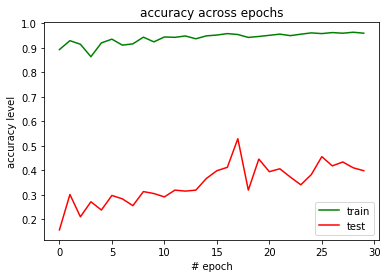

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

# show plot accuracy changes during training
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Next, we are going to evaluate the trained model against our test dataset:

In [33]:
# load weights from best model
model.load_weights(model_filepath)

# evaluate model against test set
with strategy.scope(): 
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', 'mae']) 
scores = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%% %s: %.2f%%" % (model.metrics_names[1], scores[1]*100, model.metrics_names[2], scores[2]*100))

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op __inference_distributed_function_58106 in device /job:localhost/replica:0/task:0/device:GPU:0
1956/1 [========================================================

<a name="11"></a>
## Confusion Matrix - Reminder From the Previous Lab:

---
In this section, we are going to plot the confusion matrix. While accuracy rate provides us with an overall outlook on how well our model is performing, we need more insights into the accuracy. This is especially true since our dataset is small.  We need to compromise some aspects of accuracy rate in favour of others. The `classification_report` provides us with the accuracy stats broken down into `precision`, `recall`, `f1-score`, and `support`. Before introducing these measures, let's define some abbreviations:

For brevity, we are using the following abbreviations: 
- __FP__: False Positive
- __TP__: True  Positive
- __FN__: False Negative
- __TN__: True  Negative

The first measure is focused on identifying positive cases and is called __recall__. We define recall as the ability of the model to identify all true positive samples of the dataset. In mathematical terms, recall is the ratio of true positives over true positives plus false negatives. By other means, recall tells us, among all the test samples belonging to the output class, how many of them are identified correctly by the model:

\begin{equation*}
recall = \frac{TP}{TP+FN}
\end{equation*}

The next measure, is called __precision__ and is the ability of the model to identify the relevant samples only, and is defined as the ratio of true positives over true positives plus false positives:

\begin{equation*}
precision = \frac{TP}{TP+FP}
\end{equation*}


Selecting a proper threshold usually stems from a good balance between the precision and recall values. A well-known measure that provides such a balance is `F1 score`, which is a harmonic mean of precision and recall, and defined as:

\begin{equation*}
{F_1 \: score} = 2*\frac{precision*recall}{precision+recall}
\end{equation*}

---

One very important measure is the recall rate on defective samples. We are interested in models that retrieve as many defective hard drives as possible. The downside is that the high recall rate usually results in a lower precision rate when the dataset is small. Here we are willing to accept this pitfall in favour of a higher recall rate, given the limitation on the dataset size. We try to predict at least half of the defective hard drives. Let's measure how our model is performing:

In [35]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(x_test)
conf_test = y_test.reshape(y_test.shape[0],1)
print(classification_report(conf_test, y_pred))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

In [36]:

y_pred = model.predict_classes(x_train)
conf_train = y_train.reshape(y_train.shape[0],1)
print(classification_report(conf_train, y_pred))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op __inference_distributed_function_61389 in device /job:localhost/replica:0/task:0/device:GPU:0
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4000
           1       0.83      0.71     

<a name="12"></a>
## Optional:  CNN LSTM Architecture

In this section, we are going to introduce a more advanced architecture, officially known as a __CNN LSTM Sequence Prediction__ model. This model is designed specifically for sequential prediction with spatial inputs (e.g. videos), however, could be applied to time series prediction as well.

The CNN LSTM uses a convolutional neural layer to extract features from the sequence on top of the LSTM layers which also inherently extract features. Since we are dealing with one dimensional time series, we are going to use 1D convolutional network, starting with a kernel size of 12 and 50 filters. We also use a [max pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layer of size 2 to shrink the data size. Figure 5 shows the architecture of the new model.


<img src="img/lstm_conv.png" style="margin-top:10px;width:800px;"/>
<p style="text-align: center;color:gray"> Figure 5.  CNN LSTM layers. </p>


In [37]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# model parameters
dp_lvl = 0.2
regularizer_lvl = 0.002
data_shape = x_train.shape[1:]

kernel_s = 3 # should be smaller than sequence length
filter_s = 64

with strategy.scope(): 
    # network design
    model = Sequential()
    model.add(Conv1D(kernel_size = kernel_s, filters = filter_s, padding='same', input_shape=data_shape, activation='relu'))
    model.add(Conv1D(kernel_size = kernel_s, filters = filter_s, padding='same' ,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(filter_s, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences = True ))
    model.add(LSTM(filter_s, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences = False ))
    model.add(Dense(filter_s, activation='tanh',activity_regularizer=regularizers.l2(regularizer_lvl)))
    model.add(Dropout (0.2))
    model.add(Dense(1, activation='relu',activity_regularizer=regularizers.l2(regularizer_lvl)))

# training parameters
epochs_num = 100
learning_rate = 0.001
decay_rate = 3 * learning_rate / epochs_num
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None,decay = decay_rate)

print('Training using %d GPU(s)' % strategy.num_replicas_in_sync)

# print out model
model.summary()

# checkpoint
model_fn = "best_1D_model.h5"
model_filepath=data_dir+model_fn

checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

es = EarlyStopping(patience=20, verbose=1)

callbacks_list = [es, checkpoint]

with strategy.scope(): 
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', 'mae'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Training using 2 GPU(s)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             4672      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 2, 64)             33024     
________________________________________

With the model built, let’s train the new model to determine its accuracy.

In [38]:
# fit network
model.fit(x_train, y_train, epochs=epochs_num, batch_size=16, validation_split=0.1, verbose=1, shuffle=True, callbacks=callbacks_list)

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 4536 samples, validate on 505 samples
Epoch 1/100
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in devic

Let's start out by reviewing the training loss.

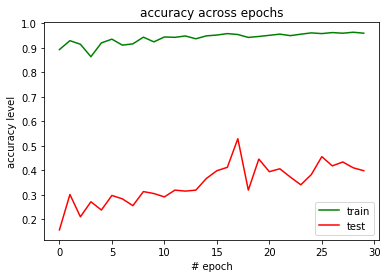

In [39]:
# show plot accuracy changes during training
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

And let's check out the overall accuracy.

In [40]:
# load weights from best model
model.load_weights(model_filepath)

# evaluate model against test set
with strategy.scope(): 
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', 'mae']) 
scores = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%% %s: %.2f%%" % (model.metrics_names[1], scores[1]*100, model.metrics_names[2], scores[2]*100))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op __inference_distributed_function_142246 in device /job:localhost/replica:0/task:0/device:GPU:0
1956/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Similar to the previous model, we are going to build the confusion matrix.

In [41]:
# confusion matrix on test set
y_pred = model.predict_classes(x_test)
conf_test = y_test.reshape(y_test.shape[0],1)
print(classification_report(conf_test, y_pred))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op __inference_distributed_function_143598 in device /job:localhost/replica:0/task:0/device:GPU:0
              precision    recall  f1-score   support

           0       0.94      0.16      0.27      1740
           1       0.12      0.92      0.21       216

    accuracy                           0.24      1956
   macro avg       0.53      0.54      0.24      1956
weighted avg       0.85      0.24      0.26      1956



## Leveraging the model for calculating "Remaining Useful Life" (RUL)

In the case above, we developed a "classifier" which will indicate, based on SMART drive data, that a given hard drive will fail within the "sequnce_length".  By increasing the sequence_length, we could potentially learn to detect failures further in the future. In addition, different failure types could have different failure windows, so an ensemble of models, each with different windows and sequences could be leveraged for more advanced RUL predictions.

In [42]:
# free up memory for upcoming exercises
gc.collect()

4368

## Group Discussion Questions

Question: What do you think about the model accuracy ?

In [ ]:
# Answer

Question: Discuss some ways that you could improve the performance of the model above ?

In [ ]:
# Answer

<a name="assess"></a>
## Assessment – Predicting Time Series

The RNN model we created in this lab was designed to output a single value, indicating whether the subject time series results in a "failed" hard drive or not. To accomplish this, a simple class label is returned by the model through the below line of tf.keras code:

```
model.add(Dense(1, activation='relu',activity_regularizer=regularizers.l2(regularizer_lvl)))
```

In this assignment, we intend to perform a slightly different approach. For example, while previously we were given with sequences of length "5" (the original value), now we assume that the length of the sequence is one less, e.g. 4 (these are arbitrary lengths for the sake of example) in our case. Predicting the 5th element of the sequence is the subject of our model. By other means, we want the model to return a single (multi-dimensional) vector, (a vector of size [1 x 47] for the above DataFrame. You should determine the vector size by the array shape). 

![image](img/Lab2-Assessment-Example.jpg)

In addition to the above criteria, there are some other changes required for the architecture of the model:

1- The model starts with two stacked LSTM layers with a unit size of 128.

2- The last output of the second LSTM layer is fed into a Dense model with the following properties: 
    - The number of outputs is 256
    - The activation function is `tanh`
    
3- The fourth layer is a dropout layer with dropout probability of 0.2

4- Next is another dense model with:
    - The number of outputs is 128
    - The activation function is `tanh`
    
5- The last layer is a Dense layer where the number of outputs is equal to the dimension of a single row of data. (Remember that we are trying to predict the values of a multi dimension vector).
    
The function should simply return the above model.
        




__To do so, open [this python file](/lab/edit/assignment.py)__  and complete the `get_model()` function by filling in the __<<< TODO >>>__ section according to the criteria described above.


Once done, you can use the following block of code to verify that your implementation is correct. Note that this is __NOT__ the last step. After you succeed the test below, you need to click on assess test button on the course page. For more details, read the red note below.

In [43]:
# reset GPUs to free up memory
from numba import cuda

for each_device in range(gpu): 
    device=cuda.select_device(each_device)
    device.reset()

In [46]:
!python try_assessment.py

{"score": 100, "message": "Your function is correct!"}


<span style="background-color:red;color:white;padding:1px,3px"><b>Note:</b></span> __Once the code is completed, go back to the assessment page (where you clicked on the current notebook) and click on the `ASSESS TASK` button. If you have correctly implemented the code, you will pass this section.__

## Summary

LSTMs provide a powerful way to analyze time series data.  While XGBoost was able to predict failure for a given set of SMART data, the LSTM gave us the ability to predict future disk failures before they happen.

One thing to remember: The amount of data, model complexity, the number of features, and the number of epochs have been reduced in this tutorial to reduce the computational (and time) burden.  If we were leveraging this model for production usage, we would train on a much larger data set.  

This training would take hours to days, and we would regularly retrain the model leveraging additional data as it became available.  Also, a key thing to remember is that the data is device and environment-dependent, so any major changes would require retraining to ensure the model was still appropriate.

<a name="All-answers"></a>
## Answers to selected exercises:
---

<a name="a1"></a>
**Exercise 1: Create class labels:**

Click [here](#e1) to go back

<a name="a2"></a>
**Exercise 2: Reshaping the training data**

Click [here](#e2) to go back